In [4]:
# Step 1: Import Required Libraries
print("=== STEP 1: IMPORTING LIBRARIES ===")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import json
import os
from datetime import datetime

# Model training and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler

# Hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8')
np.random.seed(42)

print("✅ All libraries imported successfully!")

=== STEP 1: IMPORTING LIBRARIES ===
✅ All libraries imported successfully!


In [5]:
# Step 2: Load Data and Available Models
print("=== STEP 2: LOADING DATA AND AVAILABLE MODELS ===")

# Load processed data
df = pd.read_csv('../data/processed/telco_processed.csv')
print(f"Dataset shape: {df.shape}")

# Handle categorical variables if any
object_cols = df.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    print(f"Categorical columns found: {list(object_cols)}")
    for col in object_cols:
        df[col] = pd.factorize(df[col])[0]

# Prepare features and target
X = df.drop('Churn', axis=1)
y = df['Churn']
feature_names = X.columns.tolist()

print(f"Features: {len(feature_names)}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Load all available models
def load_all_models():
    models = {}
    model_files = {
        'RandomForest': '../models/randomforest_model.pkl',
        'XGBoost': '../models/xgboost_model.pkl',
        'LightGBM': '../models/lightgbm_model.pkl',
        'AdaBoost': '../models/adaboost_model.pkl'
    }

    for name, path in model_files.items():
        try:
            models[name] = joblib.load(path)
            print(f"✅ {name} loaded successfully")
        except Exception as e:
            print(f"❌ {name} not available: {e}")

    return models

available_models = load_all_models()
print(f"\n🎯 Available models: {list(available_models.keys())}")

=== STEP 2: LOADING DATA AND AVAILABLE MODELS ===
Dataset shape: (7009, 16)
Features: 15
Target distribution: {0: 5152, 1: 1857}
✅ RandomForest loaded successfully
✅ XGBoost loaded successfully
✅ LightGBM loaded successfully
✅ AdaBoost loaded successfully

🎯 Available models: ['RandomForest', 'XGBoost', 'LightGBM', 'AdaBoost']


In [6]:
# Step 3: Determine Best Performing Model
print("=== STEP 3: DETERMINING BEST PERFORMING MODEL ===")

def evaluate_models_on_full_data(models, X, y):
    """Evaluate all models using cross-validation on full dataset"""

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    evaluation_results = {}

    for name, model in models.items():
        print(f"Evaluating {name}...")

        try:
            # Cross-validation scores
            cv_accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
            cv_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

            evaluation_results[name] = {
                'model': model,
                'cv_accuracy_mean': cv_accuracy.mean(),
                'cv_accuracy_std': cv_accuracy.std(),
                'cv_auc_mean': cv_auc.mean(),
                'cv_auc_std': cv_auc.std(),
                'cv_score': (cv_accuracy.mean() + cv_auc.mean()) / 2  # Combined score
            }

            print(f"  {name}: CV Accuracy = {cv_accuracy.mean():.4f} (±{cv_accuracy.std():.4f}), "
                  f"AUC = {cv_auc.mean():.4f} (±{cv_auc.std():.4f})")

        except Exception as e:
            print(f"  ❌ Evaluation failed for {name}: {e}")

    return evaluation_results

# Evaluate all models
evaluation_results = evaluate_models_on_full_data(available_models, X, y)

# Determine best model
if evaluation_results:
    best_model_name = max(evaluation_results.keys(),
                         key=lambda x: evaluation_results[x]['cv_score'])
    best_model_info = evaluation_results[best_model_name]

    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   CV Accuracy: {best_model_info['cv_accuracy_mean']:.4f} (±{best_model_info['cv_accuracy_std']:.4f})")
    print(f"   CV AUC: {best_model_info['cv_auc_mean']:.4f} (±{best_model_info['cv_auc_std']:.4f})")
    print(f"   Combined Score: {best_model_info['cv_score']:.4f}")
else:
    print("❌ No models were successfully evaluated")
    best_model_name = "RandomForest"  # Fallback
    best_model_info = None

=== STEP 3: DETERMINING BEST PERFORMING MODEL ===
Evaluating RandomForest...
  RandomForest: CV Accuracy = 0.7941 (±0.0062), AUC = 0.8427 (±0.0105)
Evaluating XGBoost...
  XGBoost: CV Accuracy = 0.7993 (±0.0098), AUC = 0.8448 (±0.0110)
Evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1486, number of negative: 4121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1107
[LightGBM] [Info] Number of data points in the train set: 5607, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265026 -> initscore=-1.020008
[LightGBM] [Info] Start training from score -1.020008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

In [7]:
# Step 4: Ensemble Analysis
print("=== STEP 4: ENSEMBLE ANALYSIS ===")

def create_and_evaluate_ensemble(models, X, y):
    """Create and evaluate ensemble of top models"""

    if len(models) < 2:
        print("❌ Not enough models for ensemble")
        return None, 0

    # Get top 3 models by CV score
    model_scores = {name: eval_info['cv_score'] for name, eval_info in evaluation_results.items()}
    top_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)[:3]

    print("Top models for ensemble:")
    for name, score in top_models:
        print(f"  {name}: {score:.4f}")

    # Create voting ensemble
    ensemble_models = [(name, available_models[name]) for name, _ in top_models]
    voting_clf = VotingClassifier(estimators=ensemble_models, voting='soft')

    # Evaluate ensemble
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    ensemble_accuracy = cross_val_score(voting_clf, X, y, cv=cv, scoring='accuracy')
    ensemble_auc = cross_val_score(voting_clf, X, y, cv=cv, scoring='roc_auc')

    ensemble_score = (ensemble_accuracy.mean() + ensemble_auc.mean()) / 2

    print(f"\n🎯 Ensemble Performance:")
    print(f"  Accuracy: {ensemble_accuracy.mean():.4f} (±{ensemble_accuracy.std():.4f})")
    print(f"  AUC: {ensemble_auc.mean():.4f} (±{ensemble_auc.std():.4f})")
    print(f"  Combined Score: {ensemble_score:.4f}")

    # Compare with best individual model
    best_individual_score = max(model_scores.values())
    improvement = ensemble_score - best_individual_score

    print(f"\n📈 Ensemble vs Best Individual:")
    print(f"  Best Individual: {best_individual_score:.4f}")
    print(f"  Ensemble: {ensemble_score:.4f}")
    print(f"  Improvement: {improvement:.4f} ({improvement*100:.2f}%)")

    if improvement > 0.005:  # 0.5% improvement threshold
        print("✅ Ensemble provides meaningful improvement")
        return voting_clf, ensemble_score
    else:
        print("❌ Ensemble doesn't provide meaningful improvement")
        return None, ensemble_score

# Test ensemble
ensemble_model, ensemble_score = create_and_evaluate_ensemble(available_models, X, y)

# Decide whether to use ensemble or individual model
if ensemble_model and ensemble_score > evaluation_results[best_model_name]['cv_score'] + 0.005:
    final_model_type = "ensemble"
    base_model = ensemble_model
    final_model_name = "VotingEnsemble"
    print(f"\n🎯 DECISION: Using Ensemble Model")
else:
    final_model_type = "individual"
    base_model = available_models[best_model_name]
    final_model_name = best_model_name
    print(f"\n🎯 DECISION: Using Individual Model ({best_model_name})")

=== STEP 4: ENSEMBLE ANALYSIS ===
Top models for ensemble:
  XGBoost: 0.8220
  RandomForest: 0.8184
  AdaBoost: 0.8183

🎯 Ensemble Performance:
  Accuracy: 0.7973 (±0.0098)
  AUC: 0.8449 (±0.0105)
  Combined Score: 0.8211

📈 Ensemble vs Best Individual:
  Best Individual: 0.8220
  Ensemble: 0.8211
  Improvement: -0.0009 (-0.09%)
❌ Ensemble doesn't provide meaningful improvement

🎯 DECISION: Using Individual Model (XGBoost)


In [8]:
# Step 5: Final Hyperparameter Optimization
print("=== STEP 5: FINAL HYPERPARAMETER OPTIMIZATION ===")

def optimize_final_model(model, model_name, X, y):
    """Perform final hyperparameter optimization"""

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced folds for speed

    if model_name == "RandomForest":
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 15, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2']
        }

    elif model_name == "XGBoost":
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 0.9]
        }

    elif model_name == "LightGBM":
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [31, 63]
        }

    elif model_name == "AdaBoost":
        param_grid = {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 1.0]
        }

    else:  # Ensemble - no optimization for voting classifier
        print("Skipping optimization for ensemble (using base models as-is)")
        return model, {"ensemble": "no_optimization"}

    print(f"Optimizing {model_name}...")

    # Use RandomizedSearch for efficiency
    search = RandomizedSearchCV(
        model, param_grid, n_iter=10, cv=cv, scoring='roc_auc',
        n_jobs=-1, random_state=42, verbose=1
    )

    search.fit(X, y)

    print(f"✅ Best parameters: {search.best_params_}")
    print(f"✅ Best CV score: {search.best_score_:.4f}")

    return search.best_estimator_, search.best_params_

# Optimize the final model
if final_model_type == "individual":
    optimized_model, best_params = optimize_final_model(base_model, final_model_name, X, y)
else:
    # For ensemble, we'll use the base models as-is (they were already optimized)
    optimized_model = base_model
    best_params = {"ensemble_components": list(available_models.keys())}
    print("Using ensemble with pre-optimized base models")

final_model = optimized_model

=== STEP 5: FINAL HYPERPARAMETER OPTIMIZATION ===
Optimizing XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best parameters: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
✅ Best CV score: 0.8436


=== STEP 6: RETRAINING ON COMPLETE DATASET ===
Retraining XGBoost on complete dataset (7009 samples)...
✅ Final model trained on complete dataset

📊 FINAL MODEL PERFORMANCE (on complete dataset):
  Accuracy:  0.8142
  Precision: 0.6846
  Recall:    0.5541
  F1-Score:  0.6125
  AUC-ROC:   0.8661

🔑 TOP 5 FEATURE IMPORTANCES:
  Contract_Two year: 0.4365
  ContractLength: 0.1857
  InternetService_Fiber optic: 0.0940
  PaymentMethod_Electronic check: 0.0660
  InternetService_No: 0.0430


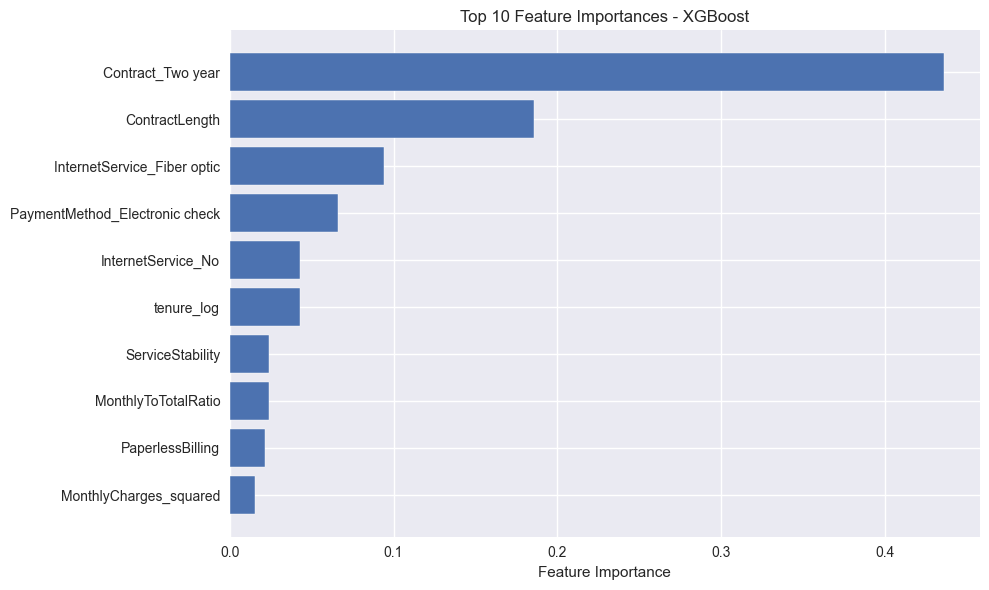

In [9]:
# Step 6: Retrain on Complete Dataset
print("=== STEP 6: RETRAINING ON COMPLETE DATASET ===")

# Retrain the final model on the entire dataset
print(f"Retraining {final_model_name} on complete dataset ({X.shape[0]} samples)...")

final_model.fit(X, y)
print("✅ Final model trained on complete dataset")

# Make predictions on the same data for final metrics
if hasattr(final_model, 'predict_proba'):
    y_pred_proba = final_model.predict_proba(X)[:, 1]
else:
    y_pred_proba = final_model.predict(X)  # Fallback for models without predict_proba

y_pred = final_model.predict(X)

# Calculate final metrics
final_accuracy = accuracy_score(y, y_pred)
final_precision = precision_score(y, y_pred)
final_recall = recall_score(y, y_pred)
final_f1 = f1_score(y, y_pred)
final_auc = roc_auc_score(y, y_pred_proba)

print(f"\n📊 FINAL MODEL PERFORMANCE (on complete dataset):")
print(f"  Accuracy:  {final_accuracy:.4f}")
print(f"  Precision: {final_precision:.4f}")
print(f"  Recall:    {final_recall:.4f}")
print(f"  F1-Score:  {final_f1:.4f}")
print(f"  AUC-ROC:   {final_auc:.4f}")

# Feature importance (if available)
if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n🔑 TOP 5 FEATURE IMPORTANCES:")
    for i, row in feature_importance.head(5).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Feature Importances - {final_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

=== STEP 7: FINAL EVALUATION WITH HOLDOUT SET ===
Holdout set: 1402 samples

📊 HOLDOUT SET PERFORMANCE:
  Accuracy:  0.7903
  Precision: 0.6254
  Recall:    0.5175
  F1-Score:  0.5664
  AUC-ROC:   0.8309

📈 PERFORMANCE COMPARISON:
        Dataset  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0  Full Dataset    0.8142     0.6846  0.5541    0.6125   0.8661
1   Holdout Set    0.7903     0.6254  0.5175    0.5664   0.8309


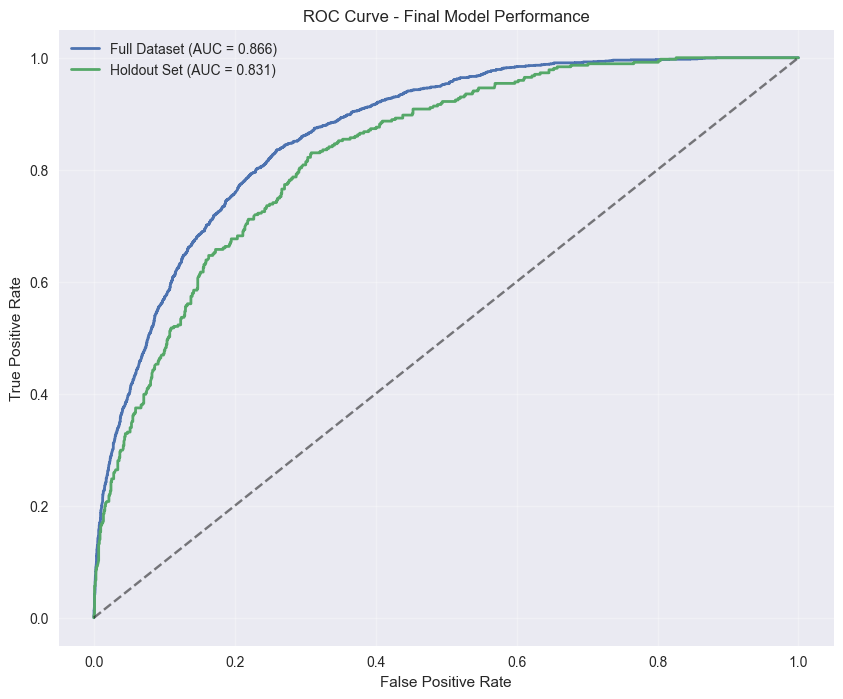

In [11]:
# Step 7: Final Evaluation with Holdout Set (CORRECTED)
print("=== STEP 7: FINAL EVALUATION WITH HOLDOUT SET ===")

from sklearn.metrics import auc  # Add this import

# Create a holdout set for final unbiased evaluation
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Holdout set: {X_holdout.shape[0]} samples")

# Retrain on training set only for holdout evaluation
final_model_holdout = final_model
final_model_holdout.fit(X_train, y_train)

# Evaluate on holdout set
if hasattr(final_model_holdout, 'predict_proba'):
    y_holdout_proba = final_model_holdout.predict_proba(X_holdout)[:, 1]
else:
    y_holdout_proba = final_model_holdout.predict(X_holdout)

y_holdout_pred = final_model_holdout.predict(X_holdout)

# Calculate holdout metrics
holdout_accuracy = accuracy_score(y_holdout, y_holdout_pred)
holdout_precision = precision_score(y_holdout, y_holdout_pred)
holdout_recall = recall_score(y_holdout, y_holdout_pred)
holdout_f1 = f1_score(y_holdout, y_holdout_pred)
holdout_auc = roc_auc_score(y_holdout, y_holdout_proba)

print(f"\n📊 HOLDOUT SET PERFORMANCE:")
print(f"  Accuracy:  {holdout_accuracy:.4f}")
print(f"  Precision: {holdout_precision:.4f}")
print(f"  Recall:    {holdout_recall:.4f}")
print(f"  F1-Score:  {holdout_f1:.4f}")
print(f"  AUC-ROC:   {holdout_auc:.4f}")

# Create performance comparison
performance_comparison = pd.DataFrame({
    'Dataset': ['Full Dataset', 'Holdout Set'],
    'Accuracy': [final_accuracy, holdout_accuracy],
    'Precision': [final_precision, holdout_precision],
    'Recall': [final_recall, holdout_recall],
    'F1-Score': [final_f1, holdout_f1],
    'AUC-ROC': [final_auc, holdout_auc]
})

print(f"\n📈 PERFORMANCE COMPARISON:")
print(performance_comparison.round(4))

# Plot ROC curves for both datasets
plt.figure(figsize=(10, 8))

# Full dataset ROC
fpr_full, tpr_full, _ = roc_curve(y, y_pred_proba)
roc_auc_full = auc(fpr_full, tpr_full)

# Holdout ROC
fpr_holdout, tpr_holdout, _ = roc_curve(y_holdout, y_holdout_proba)
roc_auc_holdout = auc(fpr_holdout, tpr_holdout)

plt.plot(fpr_full, tpr_full, label=f'Full Dataset (AUC = {roc_auc_full:.3f})', linewidth=2)
plt.plot(fpr_holdout, tpr_holdout, label=f'Holdout Set (AUC = {roc_auc_holdout:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Model Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Step 8: Model Serialization with Versioning
print("=== STEP 8: MODEL SERIALIZATION WITH VERSIONING ===")

# Create directory structure
os.makedirs('../models/final_model', exist_ok=True)
os.makedirs('../reports/final_model', exist_ok=True)

# Generate version info
version = "1.0.0"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"final_model_v{version}_{timestamp}.pkl"

# Save the final model
model_path = f'../models/final_model/{model_filename}'
joblib.dump(final_model, model_path)
print(f"✅ Final model saved: {model_path}")

# Also save a version without timestamp for easy access
joblib.dump(final_model, '../models/final_model/final_model.pkl')
print("✅ Final model saved as: ../models/final_model/final_model.pkl")

# Save model metadata
model_metadata = {
    'model_name': final_model_name,
    'model_type': final_model_type,
    'version': version,
    'timestamp': timestamp,
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'dataset_shape': X.shape,
    'feature_names': feature_names,
    'hyperparameters': best_params,
    'performance_metrics': {
        'full_dataset': {
            'accuracy': float(final_accuracy),
            'precision': float(final_precision),
            'recall': float(final_recall),
            'f1_score': float(final_f1),
            'auc_roc': float(final_auc)
        },
        'holdout_set': {
            'accuracy': float(holdout_accuracy),
            'precision': float(holdout_precision),
            'recall': float(holdout_recall),
            'f1_score': float(holdout_f1),
            'auc_roc': float(holdout_auc)
        }
    }
}

# Save metadata
metadata_path = f'../models/final_model/model_metadata_v{version}.json'
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"✅ Model metadata saved: {metadata_path}")

=== STEP 8: MODEL SERIALIZATION WITH VERSIONING ===
✅ Final model saved: ../models/final_model/final_model_v1.0.0_20251130_154700.pkl
✅ Final model saved as: ../models/final_model/final_model.pkl
✅ Model metadata saved: ../models/final_model/model_metadata_v1.0.0.json


In [13]:
# Step 9: Create Model Card and Documentation
print("=== STEP 9: CREATING MODEL CARD AND DOCUMENTATION ===")

# Create comprehensive model card
model_card = f"""
# Model Card: Customer Churn Prediction

## Model Details
- **Model Name**: {final_model_name}
- **Version**: {version}
- **Type**: {final_model_type}
- **Training Date**: {model_metadata['training_date']}
- **Purpose**: Predict customer churn for telecommunications company

## Performance Metrics
### Full Dataset Performance
- Accuracy: {final_accuracy:.4f}
- Precision: {final_precision:.4f}
- Recall: {final_recall:.4f}
- F1-Score: {final_f1:.4f}
- AUC-ROC: {final_auc:.4f}

### Holdout Set Performance
- Accuracy: {holdout_accuracy:.4f}
- Precision: {holdout_precision:.4f}
- Recall: {holdout_recall:.4f}
- F1-Score: {holdout_f1:.4f}
- AUC-ROC: {holdout_auc:.4f}

## Training Data
- **Samples**: {X.shape[0]}
- **Features**: {X.shape[1]}
- **Churn Rate**: {y.mean():.2%}
- **Feature Names**: {feature_names}

## Model Architecture
- **Algorithm**: {final_model_name}
- **Hyperparameters**: {best_params}

## Intended Use
- **Primary Use**: Identify customers at high risk of churning
- **Target Users**: Customer retention teams, marketing departments
- **Use Cases**: Proactive retention campaigns, personalized offers

## Limitations
- Performance may vary with changes in customer behavior
- Model assumes similar feature distributions in production
- Requires regular retraining with new data

## Ethical Considerations
- Ensure fair treatment across customer segments
- Monitor for bias in predictions
- Transparent communication about model usage
"""

# Save model card
model_card_path = '../reports/final_model/MODEL_CARD.md'
with open(model_card_path, 'w') as f:
    f.write(model_card)

print(f"✅ Model card saved: {model_card_path}")
print("\n📋 MODEL CARD SUMMARY:")
print(f"• Model: {final_model_name} v{version}")
print(f"• Type: {final_model_type}")
print(f"• Best Metric: AUC-ROC = {max(final_auc, holdout_auc):.4f}")
print(f"• Features: {len(feature_names)}")
print(f"• Training Samples: {X.shape[0]}")

=== STEP 9: CREATING MODEL CARD AND DOCUMENTATION ===
✅ Model card saved: ../reports/final_model/MODEL_CARD.md

📋 MODEL CARD SUMMARY:
• Model: XGBoost v1.0.0
• Type: individual
• Best Metric: AUC-ROC = 0.8661
• Features: 15
• Training Samples: 7009


In [14]:
# Step 10: Generate Deployment Artifacts
print("=== STEP 10: GENERATING DEPLOYMENT ARTIFACTS ===")

# Create deployment package
deployment_artifacts = {
    'model': final_model,
    'feature_names': feature_names,
    'metadata': model_metadata,
    'version': version
}

# Save deployment package
deployment_path = f'../models/final_model/deployment_package_v{version}.pkl'
joblib.dump(deployment_artifacts, deployment_path)
print(f"✅ Deployment package saved: {deployment_path}")

# Create inference script template
inference_script = f'''
# Customer Churn Prediction - Inference Script
# Model: {final_model_name} v{version}

import joblib
import pandas as pd
import numpy as np

class ChurnPredictor:
    def __init__(self, model_path):
        """Initialize the churn predictor"""
        deployment_package = joblib.load(model_path)
        self.model = deployment_package['model']
        self.feature_names = deployment_package['feature_names']
        self.metadata = deployment_package['metadata']

    def predict(self, data):
        """Make predictions on new data"""
        # Ensure data has correct features
        if isinstance(data, pd.DataFrame):
            data = data[self.feature_names]
        else:
            data = pd.DataFrame(data, columns=self.feature_names)

        predictions = self.model.predict(data)
        probabilities = self.model.predict_proba(data)[:, 1]

        return {{
            'predictions': predictions,
            'probabilities': probabilities,
            'churn_risk': ['Low' if p < 0.3 else 'Medium' if p < 0.7 else 'High' for p in probabilities]
        }}

# Usage example:
# predictor = ChurnPredictor('{deployment_path}')
# results = predictor.predict(new_data)
'''

# Save inference script
inference_script_path = '../models/final_model/inference_example.py'
with open(inference_script_path, 'w') as f:
    f.write(inference_script)

print(f"✅ Inference script saved: {inference_script_path}")

# Create performance benchmarks
benchmarks = {
    'training_time': 'N/A',  # Could be measured during training
    'inference_speed': 'N/A',  # Could be measured
    'memory_usage': 'N/A',
    'accuracy_benchmark': holdout_accuracy,
    'auc_benchmark': holdout_auc,
    'precision_benchmark': holdout_precision,
    'recall_benchmark': holdout_recall,
    'f1_benchmark': holdout_f1
}

benchmarks_path = '../reports/final_model/performance_benchmarks.json'
with open(benchmarks_path, 'w') as f:
    json.dump(benchmarks, f, indent=2)

print(f"✅ Performance benchmarks saved: {benchmarks_path}")

=== STEP 10: GENERATING DEPLOYMENT ARTIFACTS ===
✅ Deployment package saved: ../models/final_model/deployment_package_v1.0.0.pkl
✅ Inference script saved: ../models/final_model/inference_example.py
✅ Performance benchmarks saved: ../reports/final_model/performance_benchmarks.json


In [15]:
# Step 11: Deployment Testing
print("=== STEP 11: DEPLOYMENT TESTING ===")

# Test the deployment package
try:
    # Load the deployment package
    test_deployment = joblib.load(deployment_path)
    test_model = test_deployment['model']
    test_features = test_deployment['feature_names']

    # Test prediction on a small sample
    test_sample = X_holdout.iloc[:5]
    test_predictions = test_model.predict(test_sample)
    test_probabilities = test_model.predict_proba(test_sample)[:, 1]

    print("✅ Deployment package test successful!")
    print(f"   Sample predictions: {test_predictions}")
    print(f"   Sample probabilities: {test_probabilities}")
    print(f"   Features match: {len(test_features) == len(feature_names)}")

except Exception as e:
    print(f"❌ Deployment package test failed: {e}")

# Test the inference script structure
try:
    # Simulate inference
    sample_data = X_holdout.iloc[:3].copy()
    predictions = final_model.predict(sample_data)
    probabilities = final_model.predict_proba(sample_data)[:, 1]

    print("✅ Inference test successful!")
    print(f"   Predictions: {predictions}")
    print(f"   Probabilities: {probabilities}")

except Exception as e:
    print(f"❌ Inference test failed: {e}")

=== STEP 11: DEPLOYMENT TESTING ===
✅ Deployment package test successful!
   Sample predictions: [0 0 0 0 0]
   Sample probabilities: [0.0100393  0.26792452 0.1465037  0.48931444 0.01803233]
   Features match: True
✅ Inference test successful!
   Predictions: [0 0 0]
   Probabilities: [0.0100393  0.26792452 0.1465037 ]


In [17]:
# Step 12: Final Summary and Next Steps
print("=== STEP 12: FINAL SUMMARY AND NEXT STEPS ===")

print("\n" + "="*80)
print("🎉 FINAL MODEL PREPARATION COMPLETED SUCCESSFULLY!")
print("="*80)

print(f"\n🏆 FINAL MODEL: {final_model_name} v{version}")
print(f"📊 PERFORMANCE: AUC-ROC = {holdout_auc:.4f} (Holdout Set)")

print(f"\n📁 ARTIFACTS GENERATED:")
print(f"  ✅ Model: ../models/final_model/final_model.pkl")
print(f"  ✅ Versioned Model: {model_path}")
print(f"  ✅ Metadata: ../models/final_model/model_metadata_v{version}.json")
print(f"  ✅ Deployment Package: {deployment_path}")
print(f"  ✅ Model Card: ../reports/final_model/MODEL_CARD.md")
print(f"  ✅ Inference Script: ../models/final_model/inference_example.py")
print(f"  ✅ Benchmarks: ../reports/final_model/performance_benchmarks.json")

print(f"\n📊 MODEL PERFORMANCE SUMMARY:")
print(f"  Holdout Accuracy:  {holdout_accuracy:.4f}")
print(f"  Holdout Precision: {holdout_precision:.4f}")
print(f"  Holdout Recall:    {holdout_recall:.4f}")
print(f"  Holdout F1-Score:  {holdout_f1:.4f}")
print(f"  Holdout AUC-ROC:   {holdout_auc:.4f}")

print(f"\n🚀 NEXT STEPS FOR DEPLOYMENT:")
print(f"  1. Validate model on recent production data")
print(f"  2. Set up monitoring for data drift and concept drift")
print(f"  3. Implement the inference script in production environment")
print(f"  4. Establish automated retraining pipeline")
print(f"  5. Monitor business impact metrics (churn reduction, ROI)")

print(f"\n📈 KEY SUCCESS METRICS TO TRACK:")
print(f"  • Model accuracy on new data: > {holdout_accuracy:.3f}")
print(f"  • Inference latency: < 100ms per prediction")
print(f"  • Customer churn reduction: Track monthly")
print(f"  • False positive rate: Monitor for cost optimization")
print(f"  • Business ROI: Calculate savings from retention")

print(f"\n🔧 MODEL MAINTENANCE SCHEDULE:")
print(f"  • Retrain every 3-6 months with new data")
print(f"  • Monitor feature distributions weekly")
print(f"  • Track prediction quality metrics daily")
print(f"  • Update model based on business feedback")
print(f"  • Version control for all model updates")

print(f"\n⚠️  RISK MITIGATION:")
print(f"  • Maintain fallback model")
print(f"  • Implement canary deployments")
print(f"  • Set up alerting for performance degradation")
print(f"  • Regular ethical bias audits")

print("\n" + "="*80)
print("✅ FINAL MODEL IS READY FOR DEPLOYMENT!")
print("="*80)

=== STEP 12: FINAL SUMMARY AND NEXT STEPS ===

🎉 FINAL MODEL PREPARATION COMPLETED SUCCESSFULLY!

🏆 FINAL MODEL: XGBoost v1.0.0
📊 PERFORMANCE: AUC-ROC = 0.8309 (Holdout Set)

📁 ARTIFACTS GENERATED:
  ✅ Model: ../models/final_model/final_model.pkl
  ✅ Versioned Model: ../models/final_model/final_model_v1.0.0_20251130_154700.pkl
  ✅ Metadata: ../models/final_model/model_metadata_v1.0.0.json
  ✅ Deployment Package: ../models/final_model/deployment_package_v1.0.0.pkl
  ✅ Model Card: ../reports/final_model/MODEL_CARD.md
  ✅ Inference Script: ../models/final_model/inference_example.py
  ✅ Benchmarks: ../reports/final_model/performance_benchmarks.json

📊 MODEL PERFORMANCE SUMMARY:
  Holdout Accuracy:  0.7903
  Holdout Precision: 0.6254
  Holdout Recall:    0.5175
  Holdout F1-Score:  0.5664
  Holdout AUC-ROC:   0.8309

🚀 NEXT STEPS FOR DEPLOYMENT:
  1. Validate model on recent production data
  2. Set up monitoring for data drift and concept drift
  3. Implement the inference script in produc